Reference: https://www.kaggle.com/code/hzning/0-81-easy-is-all-you-need

In [51]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# import polar as pl
import torch.nn.functional as F
import torch.nn as nn
import torch
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from scipy.spatial.transform import Rotation as R
from sklearn.model_selection import StratifiedGroupKFold
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import f1_score, classification_report, confusion_matrix
import warnings

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Configures
FOLDS = 5
LR_INIT = 1e-3
BATCH_SIZE = 64
WD = 3e-3

MAX_LEN_PERC = 94

## 1. 📈 IMU and Gyro feature extraction

In [2]:
class ImuExtractor(nn.Module):
    def __init__(self):
        super().__init__()

        k = 15  # todo try to change this
        self.lpf_acc = nn.Conv1d(3, 3, k, padding="same", groups=3, bias=False)
        self.lpf_gyro = nn.Conv1d(3, 3, k, padding="same", groups=3, bias=False)

    def forward(self, imu: torch.Tensor):
        B, C, T = imu.shape

        acc = imu[:, :3, :]  # acc_x, acc_y, acc_z
        gyro = imu[:, 3:6, :]  # gyro_x, gyro_y, gyro_z
        extra = imu[:, 6:, :]

        # 1) Magnitude
        acc_mag = torch.norm(acc, dim=1, keepdim=True) # todo try bias=True as author did
        gyro_mag = torch.norm(gyro, dim=1, keepdim=True)

        # 2) Jerk
        jerk = F.pad(acc_mag.diff(), (1, 0))
        gyro_delta = F.pad(gyro_mag.diff(), (1, 0))

        # 3) energy # todo try without this
        acc_pow = acc**2
        gyro_pow = gyro**2

        # LPF / HPF
        acc_lpf = self.lpf_acc(acc)
        acc_hpf = acc - acc_lpf
        gyro_lpf = self.lpf_gyro(gyro)
        gyro_hpf = gyro - gyro_lpf

        # fmt: off
        features = [
            acc, gyro,
            jerk, gyro_delta,
            acc_pow, gyro_pow,
            acc_lpf, acc_hpf, gyro_lpf, gyro_hpf,
        ]
        # fmt: on

        return torch.cat(features, dim=1)

dummy_inp = torch.randn((64, 6, 40))
ImuExtractor()(dummy_inp).shape

torch.Size([64, 26, 40])

## 2. 🧠 Building Blocks

In [3]:
class SEBlock(nn.Module):
    def __init__(self, c_in, r):
        super().__init__()

        self.squeeze = nn.AdaptiveAvgPool1d(1)
        self.excitation = nn.Sequential(
            nn.Linear(c_in, c_in // r, bias=False),  # todo try with bias
            nn.ReLU(inplace=True),
            nn.Linear(c_in // r, c_in, bias=False),  # todo try with bias
            nn.Sigmoid(),
        )

    def forward(self, x: torch.Tensor):
        squeezed = self.squeeze(x).squeeze(-1)  # B x C
        weights = self.excitation(squeezed).unsqueeze(-1)  # B x C x 1

        return weights * x


SEBlock(6, 8)(dummy_inp).shape

/home/zeyadcode/.pyenv/versions/aienv/lib/python3.12/site-packages/torch/nn/init.py:511: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")


torch.Size([64, 6, 40])

## 🥟 Baseline Network

In [4]:
class BaseNet(nn.Module):
    def __init__(self, c_in, n_classes):
        super().__init__()

        # fmt: off
        self.cnn_layer = nn.Sequential(
            nn.Conv1d(c_in, 32, 3, padding="same"),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.MaxPool1d(4),
            nn.Dropout(0.1),
            
            nn.Conv1d(32, 64, 3, padding="same"),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.MaxPool1d(2),
            nn.Dropout(0.1),
        )
        
        self.pool_layer = nn.AdaptiveAvgPool1d(1)
        
        self.fc_layer = nn.Sequential(
            nn.Linear(64, n_classes),
        )
        # fmt: on

    def forward(self, x: torch.Tensor):
        x = self.cnn_layer(x)
        x = self.pool_layer(x).squeeze(-1)
        x = self.fc_layer(x)
        return x


BaseNet(c_in=dummy_inp.shape[1], n_classes=5)(dummy_inp).shape

torch.Size([64, 5])

## 🧹 Data Cleaning

## 👷 Feature Engineering

In [164]:
def get_angular_velocity(df: pd.DataFrame, delta_time=1 / 200):
    quats = df[["rot_x", "rot_y", "rot_z", "rot_w"]].values
    qt = quats[:-1, :]
    qt_plus_one = quats[1:]

    rot_t = R.from_quat(qt)
    rot_t_plus_one = R.from_quat(qt_plus_one)
    delta_rot = (rot_t.inv() * rot_t_plus_one).as_rotvec()
    angular_vel = delta_rot / delta_time
    angular_vel = np.vstack([[0, 0, 0], angular_vel])
    
    angular_dist = np.linalg.norm(angular_vel, axis=1).reshape(-1, 1)
    data = np.concatenate([angular_vel, angular_dist], axis=1)

    return pd.DataFrame(data, columns=["angular_vel_x", "angular_vel_y", "angular_vel_z", "angular_dist"], index=df.index)


def get_linear_acc(df: pd.DataFrame):
    acc = df[["acc_x", "acc_y", "acc_z"]].values
    quats = df[["rot_x", "rot_y", "rot_z", "rot_w"]].values

    rotation = R.from_quat(quats)
    gravity_world = np.array([0, 0, 9.81])
    gravity_sensor = rotation.inv().apply(gravity_world)
    linear_acc = acc - gravity_sensor

    result_df = pd.DataFrame(linear_acc, columns=["linear_acc_x", "linear_acc_y", "linear_acc_z"], index=df.index)
    return result_df


def feature_engineer(df: pd.DataFrame, inplace=False):
    if not inplace:
        df = df.copy()

    df = df.ffill().bfill().fillna(0)

    # 1) Clean Rotation
    quats = df[["rot_x", "rot_y", "rot_z", "rot_w"]].values
    zero_quat_mask = np.isclose(quats, 0).all(axis=1)
    df[zero_quat_mask][["rot_x", "rot_y", "rot_z", "rot_w"]] = np.array([0, 0, 0, 1])

    # 2) Eigen Chad
    rotation = R.from_quat(quats)
    df[["rotvec_x", "rotvec_y", "rotvec_z"]] = rotation.as_rotvec("xyz")

    rotvec_norm = np.linalg.norm(df[["rotvec_x", "rotvec_y", "rotvec_z"]].values, axis=1)
    df["rot_angle"] = np.deg2rad(rotvec_norm)
    df[["rotvec_unit_x", "rotvec_unit_y", "rotvec_unit_z"]] = df[["rotvec_x", "rotvec_y", "rotvec_z"]].div(rotvec_norm, axis=0).fillna(0)

    df["rot_angle_vel"] = df.groupby("sequence_id")["rot_angle"].diff().fillna(0)

    # 3) Linear Acceleration
    linear_acc_df = df.groupby("sequence_id").apply(get_linear_acc).droplevel(0)
    df = df.join(linear_acc_df)

    # 4) Acceleration Magnitudes
    df["acc_mag"] = np.linalg.norm(df[["acc_x", "acc_y", "acc_z"]], axis=1)
    df["linear_acc_mag"] = np.linalg.norm(df[["linear_acc_x", "linear_acc_y", "linear_acc_z"]].values, axis=1)

    # 5) Acceleration Jerk
    df[["acc_jerk_x", "acc_jerk_y", "acc_jerk_z"]] = df.groupby("sequence_id")[["acc_x", "acc_y", "acc_z"]].diff().fillna(0)
    df["acc_mag_jerk"] = df.groupby("sequence_id")["acc_mag"].diff().fillna(0)

    df[["linear_jerk_x", "linear_jerk_y", "linear_jerk_z"]] = df.groupby("sequence_id")[["linear_acc_x", "linear_acc_y", "linear_acc_z"]].diff().fillna(0)
    df["linear_acc_mag_jerk"] = df.groupby("sequence_id")["linear_acc_mag"].diff().fillna(0)

    # 6) Angular Velocity
    angular_vel_df = df.groupby("sequence_id").apply(get_angular_velocity).droplevel(0)
    df = df.join(angular_vel_df)
    
    # 7) Angular Jerk and Snap
    df[['angular_jerk_x', 'angular_jerk_y', 'angular_jerk_z']] = df[['angular_vel_x', 'angular_vel_y', 'angular_vel_z']].diff().fillna(0)
    df[['angular_snap_x', 'angular_snap_y', 'angular_snap_z']] = df[['angular_jerk_x', 'angular_jerk_y', 'angular_jerk_z']].diff().fillna(0)
    
    # 9) Return the shit
    df = df.ffill().bfill().fillna(0)
    return df

## 📁 Data Setup

In [165]:
if 'full_df' not in globals():
    full_df = pd.read_csv("../data/raw/train.csv")
    full_demographics_df = pd.read_csv("../data/raw/train_demographics.csv")
    full_df = pd.merge(
        full_df,
        full_demographics_df,
        how="left",
        on="subject",
    )
    full_df.drop(columns=[col for col in full_df.columns if col.startswith("tof_")], inplace=True)
cleaned_df = feature_engineer(full_df)

/tmp/ipykernel_100306/1909936426.py:53: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  linear_acc_df = df.groupby("sequence_id").apply(get_linear_acc).droplevel(0)
/tmp/ipykernel_100306/1909936426.py:68: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  angular_vel_df = df.groupby("sequence_id").apply(get_angular_velocity).droplevel(0)


In [170]:
# fmt: off
FEATURE_NAMES = [
    # Raw Acceleration
    "acc_x", "acc_y", "acc_z",
    'acc_jerk_x', 'acc_jerk_y', 'acc_jerk_z',
    "acc_mag", "acc_mag_jerk",

    # Linear Acceleration (gravity-compensated)
    "linear_acc_x", "linear_acc_y", "linear_acc_z",
    "linear_acc_mag", "linear_acc_mag_jerk",
    "linear_jerk_x", "linear_jerk_y", "linear_jerk_z",

    # Angular Features
    "angular_vel_x", "angular_vel_y", "angular_vel_z",
    "angular_dist",
    "angular_jerk_x", "angular_jerk_y", "angular_jerk_z",
    "angular_snap_x", "angular_snap_y", "angular_snap_z",

    # Rotation / Eigen Features
    "rot_angle", "rot_angle_vel",
    "rotvec_x", "rotvec_y", "rotvec_z",
    "rotvec_unit_x", "rotvec_unit_y", "rotvec_unit_z",
]
# fmt: on


encoder = LabelEncoder()
cleaned_df["gesture_int"] = encoder.fit_transform(cleaned_df["gesture"])

global_scalar = StandardScaler()
global_scalar = global_scalar.fit(cleaned_df[FEATURE_NAMES].values)

X_list = []
y_list = []
group_list = []
for seq_id, seq_df in cleaned_df.groupby("sequence_id"):
    group_list.append(seq_df["subject"].iloc[0])
    X_list.append(torch.tensor(seq_df[FEATURE_NAMES].values, dtype=torch.float32).permute(1, 0))
    y_list.append(torch.tensor(seq_df["gesture_int"].iloc[0]))

y_list = np.array(y_list)

In [171]:
set(cleaned_df) - set(FEATURE_NAMES)

{'adult_child',
 'age',
 'behavior',
 'elbow_to_wrist_cm',
 'gesture',
 'gesture_int',
 'handedness',
 'height_cm',
 'orientation',
 'phase',
 'rot_w',
 'rot_x',
 'rot_y',
 'rot_z',
 'row_id',
 'sequence_counter',
 'sequence_id',
 'sequence_type',
 'sex',
 'shoulder_to_wrist_cm',
 'subject',
 'thm_1',
 'thm_2',
 'thm_3',
 'thm_4',
 'thm_5'}

In [172]:
# fmt: off
TARGET_NAMES = ["Above ear - pull hair", "Forehead - pull hairline", "Forehead - scratch", "Eyebrow - pull hair", "Eyelash - pull hair", "Neck - pinch skin", "Neck - scratch", "Cheek - pinch skin"]
TARGET_NAMES_ENCODED = encoder.transform(TARGET_NAMES)
NON_TARGET_NAMES = ['Drink from bottle/cup', 'Glasses on/off', 'Pull air toward your face', 'Pinch knee/leg skin', 'Scratch knee/leg skin', 'Write name on leg', 'Text on phone', 'Feel around in tray and pull out an object', 'Write name in air', 'Wave hello']
NON_TARGET_NAMES_ENCODED = encoder.transform(NON_TARGET_NAMES)
# fmt: on

common_non_target = NON_TARGET_NAMES_ENCODED.min()  # type: ignore
effective_labels = np.concatenate(([common_non_target], TARGET_NAMES_ENCODED))
effective_names = ["Non-Target"] + TARGET_NAMES

In [173]:
X_len = np.array([len(x) for x in X_list])
maxlen = int(np.percentile(X_len, MAX_LEN_PERC))


class SensorDataset(Dataset):
    def __init__(self, X_list, y_list, maxlen, padding="post", truncate="pre") -> None:
        super().__init__()

        if padding != "post" and padding != "pre":
            raise ValueError("padding must be either 'post' or 'pre'")
        if truncate != "post" and truncate != "pre":
            raise ValueError("truncate must be either 'post' or 'pre'")

        self.X_list = X_list
        self.y_list = y_list
        self.padding = padding
        self.truncate = truncate
        self.maxlen = maxlen

    def __getitem__(self, idx):
        x = self.X_list[idx] # F x T
        y = self.y_list[idx]

        # Padding
        if x.shape[1] < self.maxlen:
            remaining = self.maxlen - x.shape[1]
            pre_pad = remaining * int(self.padding == "pre")
            post_pad = remaining * int(self.padding == "post")
            x = F.pad(x, (pre_pad, post_pad, 0, 0))

        # Truncating
        if x.shape[1] > self.maxlen:
            if self.truncate == "pre":
                remaining = x.shape[1] - self.maxlen
                x = x[:, remaining:]
            elif self.truncate == "post":
                x = x[:, :maxlen]

        return x, y

    def __len__(self):
        return len(self.X_list)

## 🏋️ Train

In [ ]:
n_features = len(FEATURE_NAMES)
n_classes = len(encoder.classes_)

frq_analysis = 20
epochs = 200
criterion = nn.CrossEntropyLoss()

skf = StratifiedGroupKFold(n_splits=FOLDS, shuffle=True)

cms = [None] * FOLDS
clsf_reports = [None] * FOLDS

for fold, (train_indices, test_indices) in enumerate(skf.split(X_list, y_list, group_list)):
    print(f"\n---- FOLD {fold + 1}/{FOLDS} ----\n")

    X_train = [X_list[i] for i in train_indices]
    y_train = [y_list[i] for i in train_indices]
    X_test = [X_list[i] for i in test_indices]
    y_test = [y_list[i] for i in test_indices]

    # Normalize
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        concatinated = np.concatenate(X_train, axis=1)  # F x T_all
        mue = np.mean(concatinated, axis=1).reshape(-1, 1)
        std = np.std(concatinated, axis=1).reshape(-1, 1)
        X_train = [(seq - mue) / (std + 1e-14) for seq in X_train]
        X_test = [(seq - mue) / (std + 1e-14) for seq in X_test]
    # Normalize ends

    model = BaseNet(n_features, n_classes)
    opt = optim.Adam(model.parameters(), lr=LR_INIT, weight_decay=WD)

    dataset_train = SensorDataset(X_train, y_train, maxlen, padding="post", truncate="pre")
    dataloader_train = DataLoader(dataset_train, batch_size=BATCH_SIZE, shuffle=True)
    dataset_test = SensorDataset(X_test, y_test, maxlen, padding="post", truncate="pre")
    dataloader_test = DataLoader(dataset_test, batch_size=BATCH_SIZE, shuffle=True)

    # Train
    for epoch in range(epochs):
        model.train()
        avg_loss_train = 0
        for x, y in dataloader_train:
            x = x.to(device)
            y = y.to(device)

            y_pred = model(x)
            loss = criterion(y_pred, y)
            avg_loss_train += loss

            opt.zero_grad()
            loss.backward()
            opt.step()

        avg_loss_train /= len(dataloader_train)

        # Validation
        if (epoch + 1) % frq_analysis == 0:
            model.eval()

            all_preds = []
            all_true_labels = []
            avg_loss_test = 0

            with torch.no_grad():
                for x, y in dataloader_test:
                    x = x.to(device)
                    y = y.to(device)

                    y_pred = model(x)
                    loss = criterion(y_pred, y)
                    avg_loss_test += loss

                    all_preds.append(y_pred.argmax(dim=1).detach().cpu().numpy())
                    all_true_labels.append(y.detach().cpu().numpy())

            avg_loss_test /= len(dataloader_test)

            all_true_labels = np.concat(all_true_labels)
            all_preds = np.concat(all_preds)

            # Group Non-Target
            all_true_labels[np.isin(all_true_labels, NON_TARGET_NAMES_ENCODED)] = common_non_target
            all_preds[np.isin(all_preds, NON_TARGET_NAMES_ENCODED)] = common_non_target

            # Create Binary Masks
            all_true_bin = np.isin(all_true_labels, TARGET_NAMES_ENCODED)
            all_preds_bin = np.isin(all_preds, TARGET_NAMES_ENCODED)

            # F1 Score
            macro_f1 = f1_score(all_true_labels, all_preds, average="macro")
            binary_f1 = f1_score(all_true_bin, all_preds_bin, average="binary")
            competition_score = 0.5 * macro_f1 + 0.5 * binary_f1

            # classification_report and confusion matrix
            cms[fold] = confusion_matrix(  # type: ignore
                all_true_labels,
                all_preds,
                labels=effective_labels,
            )

            clsf_reports[fold] = classification_report(  # type: ignore
                all_true_labels,
                all_preds,
                labels=effective_labels,
                target_names=effective_names,
                digits=4,
                zero_division=0,
                output_dict=False,
            )

            print(f"{epoch + 1}/{epochs} | Train Loss {avg_loss_train:.2f} | Test Loss {avg_loss_test:.2f} | Macro F1 {macro_f1:.2f} | Binary F1 {binary_f1:.2f} | Competition {competition_score:.2f}")


---- FOLD 1/5 ----

20/200 | Train Loss 1.22 | Test Loss 1.32 | Macro F1 0.42 | Binary F1 0.94 | Competition 0.68
40/200 | Train Loss 1.12 | Test Loss 1.27 | Macro F1 0.45 | Binary F1 0.95 | Competition 0.70
60/200 | Train Loss 1.06 | Test Loss 1.25 | Macro F1 0.48 | Binary F1 0.94 | Competition 0.71
80/200 | Train Loss 1.04 | Test Loss 1.21 | Macro F1 0.49 | Binary F1 0.95 | Competition 0.72
100/200 | Train Loss 1.01 | Test Loss 1.23 | Macro F1 0.49 | Binary F1 0.94 | Competition 0.72
120/200 | Train Loss 1.00 | Test Loss 1.19 | Macro F1 0.51 | Binary F1 0.94 | Competition 0.73
140/200 | Train Loss 0.98 | Test Loss 1.19 | Macro F1 0.48 | Binary F1 0.95 | Competition 0.71
160/200 | Train Loss 0.97 | Test Loss 1.12 | Macro F1 0.51 | Binary F1 0.95 | Competition 0.73
180/200 | Train Loss 0.95 | Test Loss 1.16 | Macro F1 0.51 | Binary F1 0.94 | Competition 0.73
200/200 | Train Loss 0.96 | Test Loss 1.18 | Macro F1 0.49 | Binary F1 0.95 | Competition 0.72

---- FOLD 2/5 ----

20/200 | Tra

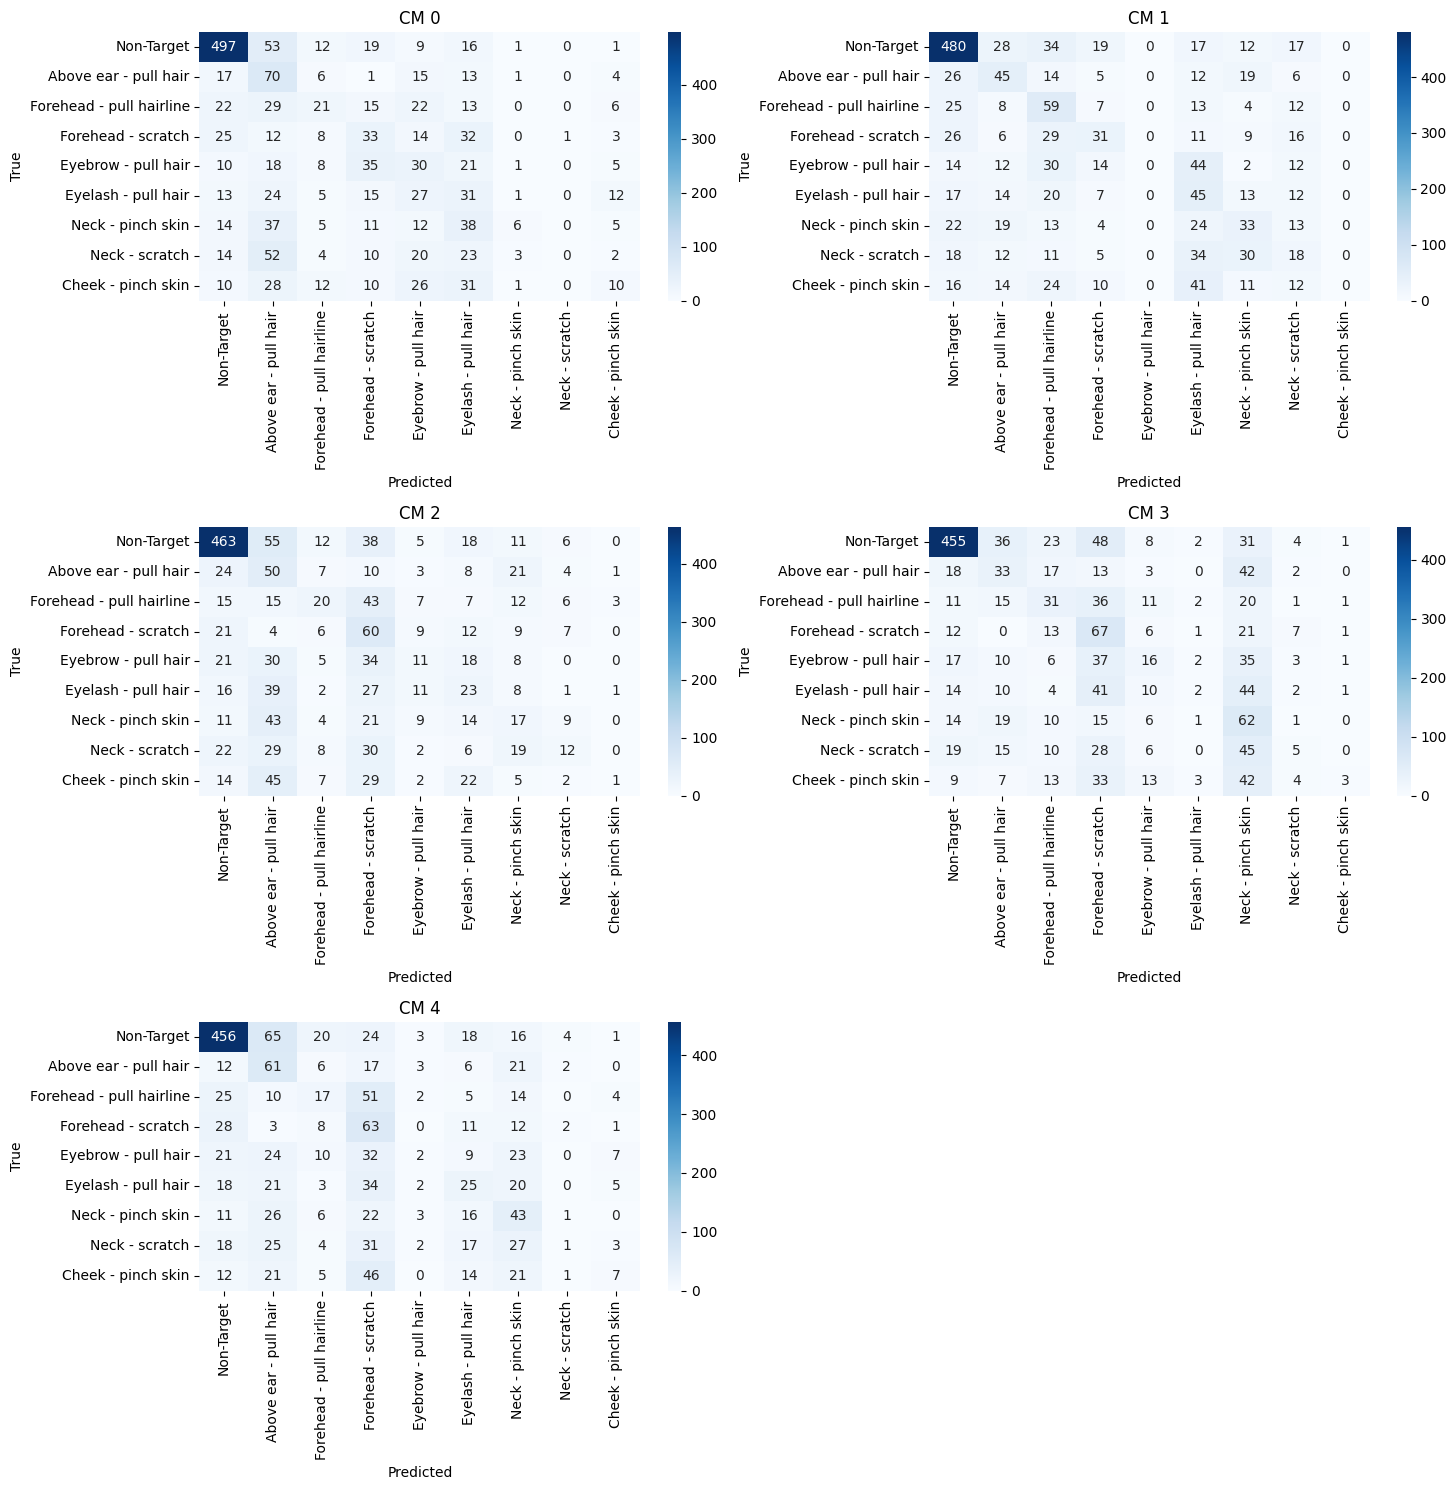

In [116]:
plt.figure(figsize=(15, 15))
for i in range(FOLDS):
    plt.subplot(3, 2, i + 1)
    sns.heatmap(
        cms[i],
        annot=True,
        fmt="d",
        cmap="Blues",
        xticklabels=effective_names,
        yticklabels=effective_names,
    )
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title(f"CM {i}")

plt.tight_layout()